In [ ]:
!pip install wget #For colab

In [ ]:
import wget, argparse, zipfile, tarfile, sys
from pathlib import Path

def simple_progress_bar(current, total, width=80):
    progress_message = "Downloading: %d%% [%d / %d] bytes" % (current / total * 100, current, total)
    sys.stdout.write("\r" + progress_message); sys.stdout.flush()

def get_and_unpack(url, location='data/'):
    Path(location).mkdir(exist_ok=True)
    filename = wget.download(url, out=location, bar=simple_progress_bar)
    zip_ref = zipfile.ZipFile(filename, 'r')
    zip_ref.extractall(path=location)
    zip_ref.close()

In [ ]:
get_and_unpack(url='http://www.welchlabs.io/unccv/deep_learning/bbc_train.zip')

Downloading: 100% [90591239 / 90591239] bytes

In [ ]:
from fastai.vision import *
path=Path('data/bbc_train')

In [ ]:


# get_y_func = lambda o:img2bbox[o.name]
def get_y_fn(x):
   return path/'masks'/(x.stem + '.png')


classes = array(['background', 'brick', 'ball', 'cylinder'])

src = (SegmentationItemList.from_folder(path/'images')
       .split_by_rand_pct(0.2)
       .label_from_func(get_y_fn, classes=classes))

#Don't normalize data here - assume normalization happens inside of Model. 
data = (src.transform(get_transforms(), tfm_y=True, size=(256,256)).databunch(bs=16).normalize(imagenet_stats))

In [ ]:
def my_accuracy(yhat, y):
    y=y.cpu()
    class_labels=torch.tensor([np.unique(y[i][y[i]!=0])[0] for i in range(y.shape[0])])
    class_labels = class_labels.to('cuda')
    return accuracy(yhat[0], class_labels.view(-1))

def my_l1(yhat, y):
    y=y.cpu()
    bboxes=torch.zeros((y.shape[0], 4))
    for i in range(y.shape[0]):
      rows,cols= np.where(y[i, 0]!=0)
      bboxes[i, :] = torch.tensor([rows.min(), cols.min(), rows.max(), cols.max()])
    return nn.L1Loss()(yhat[1], bboxes.to('cuda'))

def pixel_accuracy(yhat, y):
    y_=y.squeeze(dim=1)
    # yhat=np.array(yhat)
    yhat_=yhat[2].argmax(dim=1)
    return (y_==yhat_).sum().float()/y.numel()

# def my_accuracy(yhat, bbox_tgts, class_tgts, seg_tgts):
#     return accuracy(yhat[:,4:8], class_tgts.view(-1))

# def my_l1(yhat, bbox_tgts, class_tgts, seg_tgts):
#     return nn.L1Loss()(yhat[:,:4].unsqueeze_(dim=1), bbox_tgts)



In [ ]:
class MyLoss(nn.Module):
  def forward(self, yhat, y):
    y=y.cpu()
    class_labels=torch.tensor([np.unique(y[i][y[i]!=0])[0] for i in range(y.shape[0])])
    bboxes=torch.zeros((y.shape[0], 4))
    for i in range(y.shape[0]):
      rows,cols= np.where(y[i, 0]!=0)
      bboxes[i, :] = torch.tensor([rows.min(), cols.min(), rows.max(), cols.max()])
    cls_loss=nn.CrossEntropyLoss()(yhat[0],class_labels.to('cuda'))
    det_loss=nn.L1Loss()(yhat[1], bboxes.to('cuda'))
    y=y.to('cuda')
    seg_loss = nn.CrossEntropyLoss()(yhat[2],y.squeeze(dim=1))
    return (1*det_loss) + (1*cls_loss) + (1*seg_loss)

In [ ]:
def conv_trans(ni, nf, ks = 4, stride = 2, padding = 1):
    return nn.Sequential(
        nn.ConvTranspose2d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding = padding), 
        nn.ReLU(inplace = True), 
        nn.BatchNorm2d(nf))

class CustomHead(nn.Module):

  def __init__(self):

    super().__init__()
    
    self.clf = nn.Sequential(
    AdaptiveConcatPool2d((4,4)),
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(16384,256), #2*512*4*4
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4))

    self.det = nn.Sequential(
    AdaptiveConcatPool2d((4,4)),
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(16384,256), #2*512*4*4
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4))
    
    self.seg = nn.Sequential(
    conv_trans(512, 256), 
    conv_trans(256, 128),
    conv_trans(128, 64),
    conv_trans(64, 32), 
    nn.ConvTranspose2d(32, 4, kernel_size=4, bias=False, stride=2, padding = 1))

  def forward(self, x):
    return self.clf(x), self.det(x), self.seg(x)

In [ ]:
learn=cnn_learner(data, models.resnet34, custom_head=CustomHead(), loss_func=MyLoss(), metrics=[my_accuracy, my_l1, pixel_accuracy]) 

In [ ]:
learn.freeze()

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


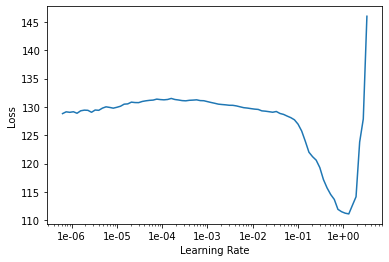

In [ ]:
learn.recorder.plot()


In [ ]:
lr=1e-1
learn.fit_one_cycle(10, slice(lr/10, lr))

epoch,train_loss,valid_loss,my_accuracy,my_l1,pixel_accuracy,time
0,116.975204,77.183571,0.904255,76.658684,0.926512,00:18
1,51.606464,18.078424,0.675532,15.764060,0.949199,00:17
2,29.681637,14.157215,0.904255,13.670094,0.966571,00:17
3,23.122383,14.261357,0.547872,9.789344,0.958277,00:17
4,19.911936,13.664985,0.861702,13.018364,0.969066,00:17
5,17.241076,9.517567,0.962766,9.343782,0.975604,00:17
6,15.418656,6.778888,0.968085,6.608541,0.979164,00:17
7,14.483128,10.246709,0.968085,10.087475,0.979367,00:18
8,13.444229,5.970631,0.989362,5.904320,0.985060,00:18
9,12.808904,5.825985,0.984043,5.759972,0.986912,00:17


In [ ]:
learn.unfreeze

<bound method Learner.unfreeze of Learner(data=ImageDataBunch;

Train: LabelList (754 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: data/bbc_train/images;

Valid: LabelList (188 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: data/bbc_train/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


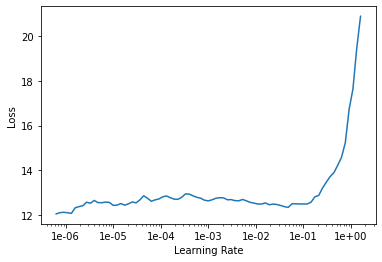

In [ ]:
learn.recorder.plot()

In [ ]:
lr = 1e-06
learn.fit_one_cycle(8, slice(lr/10, lr))

epoch,train_loss,valid_loss,my_accuracy,my_l1,pixel_accuracy,time
0,12.152530,5.520020,0.989362,5.453507,0.986973,00:18
1,12.086330,5.322492,0.989362,5.260610,0.986944,00:18
2,12.184755,6.224977,0.989362,6.159560,0.986836,00:18
3,12.367646,5.002672,0.989362,4.941983,0.986796,00:18
4,12.315938,6.071675,0.978723,6.003509,0.987042,00:18
5,12.299335,5.168837,0.978723,5.100629,0.986846,00:18
6,12.445907,5.327309,0.984043,5.258106,0.987002,00:18
7,12.189687,5.561463,0.984043,5.492554,0.987027,00:18


In [ ]:
learn.export('/content/drive/My Drive/export.pkl')